**Nome:** Iran Freitas Ribeiro

**Matrícula:** 2021241588

**Disciplina:** TEI - Estatística Aplicada

**Professor:** Celso José Munaro

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
dados = pd.read_csv("F4.txt", sep="\s+", header=None)
dados_normais = dados.iloc[:160, :]
m_n = dados_normais.mean(axis=0)
std_n = dados_normais.std(axis=0)
# remoção das médias e normalização
dados = dados - m_n
dados = dados/std_n

**1. Use as primeiras 100 amostras de Y para fazer a análise por componentes principais (CP) e plote um gráfico mostrando a variância (0 a 100% da variância) retida nos dados ao se adicionar gradativamente mais componentes principais. Quantas CP são necessárias para reter 70% da variância?**

In [3]:
# seleção das 100 primeiras amostras
amostra_100 = dados.iloc[:100, :].values
cov_matriz = np.cov(amostra_100.T)
## calcula os autovalores/vetores
#OBS: no python, os autovalores não necessariamente estão ordenados do maior para o menor
autovalores, autovetores = np.linalg.eig(cov_matriz)
# orderna os autovalores do maior para o menor
ord_autovalores =  sorted(autovalores, reverse=True)

A variância total dos dados pode ser obtida a partir da soma dos autovalores. A variância retida pode ser obtida pela soma cumulativa dos autovalores.

In [4]:
var_total = sum(ord_autovalores) # variância total
var_retida = (np.array(ord_autovalores).cumsum()/var_total)*100 # soma cumulativa das variâncias

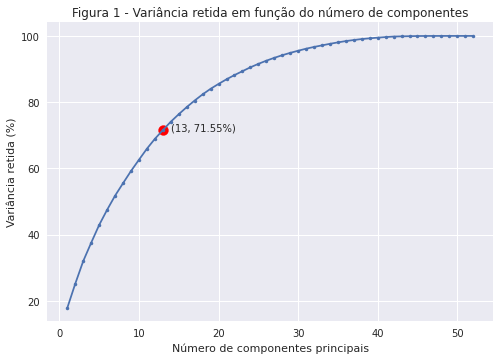

In [5]:
fig, ax = plt.subplots()
ponto = [13, var_retida[12]]
x = np.arange(1,53)
ax.plot(x, var_retida, marker='.')
ax.scatter(ponto[0], ponto[1], s=100, c='red', marker='o')
ax.text(ponto[0]+1, ponto[1], s='({}, {:.2f}%)'.format(ponto[0], ponto[1]))
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Variância retida (%)")
plt.title("Figura 1 - Variância retida em função do número de componentes");

A Figura $1$ mostra que é possível reter $71.55\%$ da variância utilizando $13$ componentes principais.

In [6]:
def indices_autovalores(a, oa, nc=2):
    indices = [np.where(np.isclose(a, oa[i]))[0][0] for i in range(nc)]
    return indices

**2. Use apenas 2 componentes principais plotadas em um gráfico de dispersão para mostrar a possibilidade de separar os dados de normalidade e falha.**

In [7]:
id_cp2 = indices_autovalores(autovalores, ord_autovalores, nc=2)
# dados_n = dados.iloc[:160, :].values
dados_normais_p = dados.iloc[:160, :].values.dot(autovetores[:, id_cp2])
dados_falha_p = dados.iloc[160:, :].values.dot(autovetores[:, id_cp2])

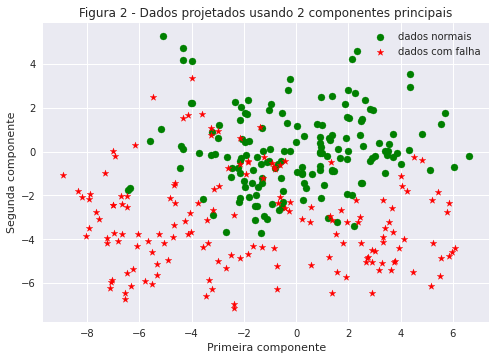

In [8]:
plt.scatter(dados_normais_p[:,0],dados_normais_p[:,1], label="dados normais", c='green')
plt.scatter(dados_falha_p[:,0],dados_falha_p[:,1], label="dados com falha", marker='*', c='red')
plt.title("Figura 2 - Dados projetados usando 2 componentes principais")
plt.xlabel("Primeira componente")
plt.ylabel("Segunda componente")
plt.legend();

A Figura $2$ mostra os dados com normalidade e com falha projetados sobre 2 componentes principais. Nota-se que, no geral, os dados com normalidade e com falha localizam-se em posições levemente opostas no gráfico de dispersão. Os dados com normalidade distribuem-se mais pela parte superior e os dados com falha mais pela parte inferior. Entretanto, há muitos dados dos dois tipos no centro do gráfico, indicando que não é possível separar os dados de normalidade dos dados com falha.

**3. Usando apenas as primeiras 100 amostras, calcule a estatística $T^2$ usando PCA retendo 70% da variância. Aplique então a estatística às 320 amostras e plote seu gráfico junto com o limiar de controle. Calcule FDR e FAR como no ECP 10, considerando que as amostras de 1 a 160 são de normalidade e as de 161 a 320 são de falha.**

In [19]:
def limiar_t2(n_cp, n):
    """
    Limiar para a estatística T²
    """
    p1 = (n_cp * (n-1) * (n+1))/(n * (n - n_cp))
    p3 = f.ppf(0.95, n_cp, n-n_cp)
    return p1*p3

def T2(X, N):
    """
    Valores para a estatística T²
    """
    S = np.cov(X.T) # matriz de covariância
    t2 = []
    Si = np.linalg.inv(S) # matriz inversa de S
    for i in range(N):
        a = X[i, :] @ Si @ X[i,:].T
        t2.append(a)
    return t2

def FDR(TP, FN):
    return TP/(TP+FN)
def FAR(FP, TN):
    return FP/(FP+TN)

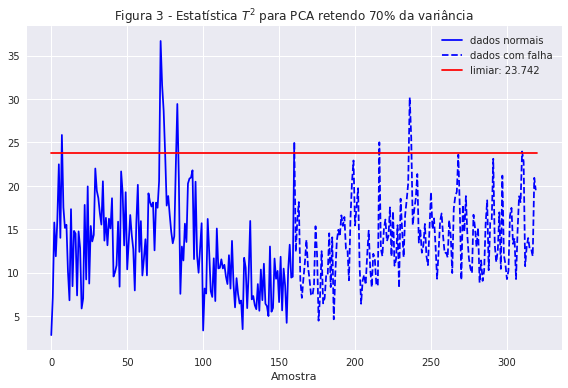

In [10]:
id_cp13 = indices_autovalores(autovalores, ord_autovalores, nc=13)
X = dados.values.dot(autovetores[:, id_cp13])
l = limiar_t2(13, 320)
t2X = T2(X, 320)
fig, ax = plt.subplots()
xl = [0, 320]
yl = [l, l]
xnorm = np.arange(161)
xfalha = np.arange(160, 320)
ax.plot(xnorm, t2X[:161],c='blue', label='dados normais')
ax.plot(xfalha, t2X[160:],c='blue', ls='--', label='dados com falha')
ax.plot(xl, yl, c='r', label='limiar: {:.3f}'.format(l))
ax.set_xlabel("Amostra")
ax.set_title(r'Figura 3 - Estatística $T^2$ para PCA retendo 70% da variância')
plt.legend()
plt.tight_layout();

A Figura $3$ mostra os dados projetados utilizando a estatística $T^2$ para $70\%$ da variância retida com o PCA. O limiar encontrado para estatística $T^2 (23.742)$ indentifica, incorretamente, $3$ erros nos dados com normalidade (primeiros $160$ dados) e $2$ erros nos dados com falha. Nesse caso, era esperado que alguns dados com normalidade fossem indentificados como falha, pelo nível de confiança utilizado ($95\%$). Além disso, os dados normais e falhas tem valores muito parecidos, sendo praticamente impossível definir um limiar que, ao mesmo tempo, indentifique as falhas sem que dados normais também sejam classificados como falha.

In [11]:
TP = sum(t2X[160:]>l) # falhas que ultrapassam o limiar
TN = sum(t2X[:160]<l) # normais que não ultrapassam o limiar
FP = sum(t2X[:160]>l) # normais que ultrapassam o limiar
FN = sum(t2X[160:]<l) # falhas que não ultrapassam o limiar

In [12]:
print ("FDR: {:.3f}".format(FDR(TP, FN)))
print ("FAR: {:.3f}".format(FAR(FP, TN)))

FDR: 0.031
FAR: 0.031


O resultado do FDR mostra que o limiar da estatística $T^2$ vai classificar, incorrentamente, $3.1\%$ das amostras. Ou seja, $3.1\%$ de amostras normais serão identificadas como falsas (ultrapassam o limiar) e $1.9\%$ das amostras com falha não serão identificadas (não ultrapassam o limiar).

O FAR, por outro lado, indica a proporção de ocorrêncais de falsos positivos. Nesse caso, usando o limiar acima tem-se também que $3.1\%$ das amostras com normalidade são indentificadas como falha. Isso de fato era esperado, já que o nível de confiança definido estima que pelo menos $5\%$ de amostras sejam incorretamente classificadas.

**4. Avalie FAR e FDR variando o número de CP (e variância retida).**

In [15]:
lista_componentes = np.arange(2, 53)
fdrs = []
fars = []
for cp in lista_componentes:
    indice_cp = indices_autovalores(autovalores, ord_autovalores, nc=cp)
    X = dados.values.dot(autovetores[:, indice_cp])
    l = limiar_t2(cp, 320)
    t2X = T2(X, 320)
    TP = sum(t2X[160:]>l) # falhas que ultrapassam o limiar
    TN = sum(t2X[:160]<l) # normais que não ultrapassam o limiar
    FP = sum(t2X[:160]>l) # normais que ultrapassam o limiar
    FN = sum(t2X[160:]<l) # falhas que não ultrapassam o limiar
    fdrs.append(FDR(TP, FN))
    fars.append(FAR(FP, TN))

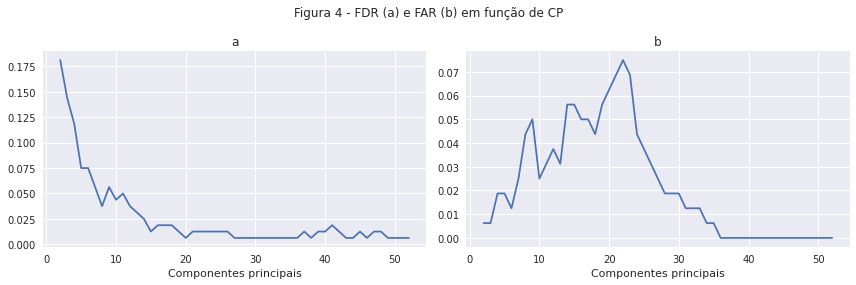

In [16]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(lista_componentes, fdrs)
ax[1].plot(lista_componentes, fars)
ax[0].set_title("a")
ax[0].set_xlabel("Componentes principais")
ax[1].set_xlabel("Componentes principais")
ax[1].set_title("b")
plt.suptitle("Figura 4 - FDR (a) e FAR (b) em função de CP")
plt.tight_layout();

A Figura $4$ mostra a variação do FDR (a) e FAR (b) em função no número de componentes principais (CP) utilizadas (variando de $2$ à $52$). Nota-se que o FDR tende à ficar menor à medida que mais CPs são utilizadas, ou seja, a ocorrência de falsos negativos diminui e oscila próximo de $0.0$ para um número de componentes maiores que $19$. Por outro lado, o valor de FAR tende a aumentar de enquanto o número de CP utilizadas é menor que $23$. A partir daí o valor de FAR decai até ficar constante em $0.0$ para um número de CP maior que $35$.

**5. Verifique se esse monitoramento multivariado poderia ser feito sem o uso de PCA, diretamente com a matriz de covariância.**

In [17]:
t2x = T2(dados.values, 320)

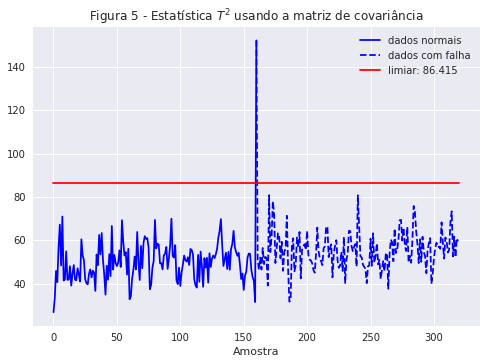

In [21]:
X = dados.values
l = limiar_t2(52, 320)
fig, ax = plt.subplots()
xl = [0, 320]
yl = [l, l]
xnorm = np.arange(161)
xfalha = np.arange(160, 320)
ax.plot(xnorm, t2X[:161],c='blue', label="dados normais")
ax.plot(xfalha, t2X[160:],c='blue', ls='--', label="dados com falha")
ax.plot(xl, yl, c='r', label="limiar: {:.3f}".format(l))
ax.set_xlabel("Amostra")
plt.legend()
plt.title("Figura 5 - Estatística $T^2$ usando a matriz de covariância");

Como mostra a Figura $5$, o monitoramente pode ser feito, mas com pouca eficiência, pois o limiar obtido usando todos a matriz de covariância só detecta uma falha no ponto onde os dados passam da normalidade para a falha (amostra $160$). No restante do tempo mais nenhuma falha é detectada.

**6. Faça o monitoramento usando a estatística Q**